## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [1]:
import numpy as np
from scipy.optimize import fsolve
import xml.etree.ElementTree as ET
from scipy.integrate import simpson
from const import *
import matplotlib.pyplot as plt
import ldfparser
from scipy.integrate import solve_ivp

In [2]:
class Iterative_method():
    def __init__(self, ne, Te, V_sat, I_sat, V_p):
        Tm = 0.1
        self.ne = ne
        self.Te = Te
        self.V_sat = V_sat
        self.I_sat = I_sat
        self.gamma = self.Te/Tm
        self.V_p = V_p
        self.De = np.sqrt(epsilon_0*kB*Te/(e**2*ne)) #electron debye length
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(ne,Te,V_sat,I_sat))
        
    def alpha_convert(self,a_0):
        def eqn21(a_s):
            return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+self.gamma*a_s)*(1-self.gamma))
        ans_arr = np.round(fsolve(eqn21,np.logspace(-2,2,5)),4)
        ans_arr = np.unique(ans_arr)
        a_s = min(ans_arr)
        print("a_0: {:.4f}\t a_s: {}\t gamma: {:.4f}\t sol_number: {}".format(a_0, a_s, self.gamma, len(ans_arr)))
        return a_s
    
    def modified_Bohm(self,a_s):
        uB = np.sqrt(e*self.Te/Mp)*np.sqrt((1+a_s)/(1+self.gamma*a_s))
        return uB
    
    def r_sh_calculation(self, J): 
            r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/Mp)*(self.V_sat - self.V_p)**1.5/J)
            #r_sh = rp
            return r_sh
            
    def iteration(self):
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(self.ne,self.Te,self.V_sat,self.I_sat))
        count = 0
        a_0 = 3
        r_sh_0 = rp
        S_eff = 2*(np.pi)*r_sh_0*lp
        
        while True:
            MAX_COUNT = 100
            count += 1
            a_s = self.alpha_convert(a_0)
            uB = self.modified_Bohm(a_s) # uB_k
            n_p = self.I_sat/(hr*S_eff*e*uB) # np_k , S_k-1
            comp = a_0 # for loop condition
            a_0 = n_p/self.ne-1 # a_0_k
            J = hr*e*n_p*uB # J_k
            r_sh = self.r_sh_calculation(J) #r_sh_k
            S_eff = 2*np.pi*r_sh*lp
            
            #print(count, a_0)
            
            if abs(comp - a_0) < 0.001*a_0:
                return a_0
                break
            if count == MAX_COUNT:
                print('-----------No Convergence!---------------------')
                break
        print('--------------------------------------------------')

In [3]:
def cal_sat(IV_df):
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    return -V[0], -I[0]

def cal_Vp(IV_df):
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    dIdV = np.gradient(I, V)
    Vp = V[np.argmax(dIdV)]
    return Vp

def cal_eepf(IV_df):
    Vp = cal_Vp(IV_df)
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    
    I_adj = I[V<=Vp]
    V_adj = V[V<=Vp]-Vp
    dI = np.gradient(I_adj, V_adj)
    ddI = np.gradient(dI, V_adj)
    eepf = 2*ddI/e/Ap*np.sqrt(2*Me*(Vp-V_adj)/e)/np.sqrt(Vp-V_adj)
    eedf = 2*ddI/e/Ap*np.sqrt(2*Me*(Vp-V_adj)/e)
    return np.flip(-V_adj), np.flip(eepf), np.flip(eedf)

def cal_ne(V, eepf, V_lim):
    mask = V < V_lim
    eepf = eepf[mask]
    V = V[mask]
    return simpson(eepf, V)

def cal_Te(V, eedf, ne, V_lim):
    mask = V < V_lim
    eedf = eedf[mask]
    V = V[mask]
    return 2/3*simpson(eedf/ne*V, V)

In [4]:
#workDir = './211216(SF6)/bias (float) 0mm B-field/'
workDir = './211221(SF6)/SF6/B field scan_20V 0mm/'
parser = ldfparser.LDF(workDir)

no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/50.ldf


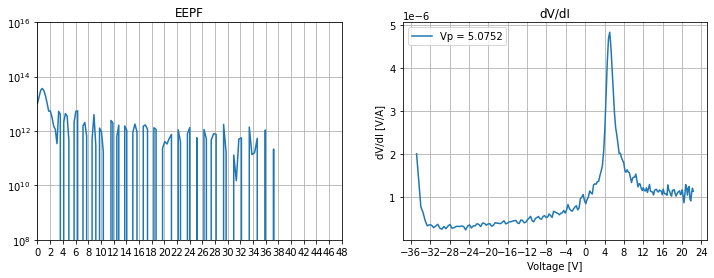

Enter limited energy
ne: 3.978e+13 [m-3]	 Te: 0.536 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.6716	 gamma: 5.3623	 sol_number: 1
a_0: 7108.3745	 a_s: 4732.4709	 gamma: 5.3623	 sol_number: 1
a_0: 2878.7970	 a_s: 1916.3908	 gamma: 5.3623	 sol_number: 1
a_0: 1672.6500	 a_s: 1113.3303	 gamma: 5.3623	 sol_number: 1
a_0: 1274.7835	 a_s: 848.4282	 gamma: 5.3623	 sol_number: 1
a_0: 1112.8249	 a_s: 740.5951	 gamma: 5.3623	 sol_number: 1
a_0: 1039.7138	 a_s: 691.9173	 gamma: 5.3623	 sol_number: 1
a_0: 1004.9744	 a_s: 668.7876	 gamma: 5.3623	 sol_number: 1
a_0: 988.0410	 a_s: 657.5132	 gamma: 5.3623	 sol_number: 1
a_0: 979.6812	 a_s: 651.9472	 gamma: 5.3623	 sol_number: 1
a_0: 975.5278	 a_s: 649.1818	 gamma: 5.3623	 sol_number: 1
a_0: 973.4577	 a_s: 647.8035	 gamma: 5.3623	 sol_number: 1
a_0: 972.4243	 a_s: 647.1155	 gamma: 5.3623	 sol_number: 1
Vp: 5.07517, Vsat: 34.8019, Isat: 3.09005e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/60.ldf


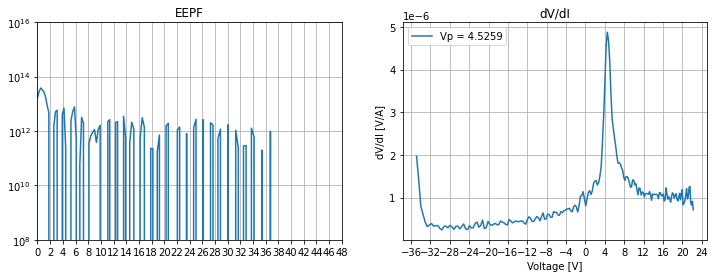

Enter limited energy
ne: 4.234e+13 [m-3]	 Te: 0.486 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.7105	 gamma: 4.8628	 sol_number: 1
a_0: 6705.4876	 a_s: 4507.2071	 gamma: 4.8628	 sol_number: 1
a_0: 2647.9136	 a_s: 1779.6491	 gamma: 4.8628	 sol_number: 1
a_0: 1525.3680	 a_s: 1025.0582	 gamma: 4.8628	 sol_number: 1
a_0: 1157.5453	 a_s: 777.8027	 gamma: 4.8628	 sol_number: 1
a_0: 1008.3043	 a_s: 677.4808	 gamma: 4.8628	 sol_number: 1
a_0: 941.0427	 a_s: 632.2666	 gamma: 4.8628	 sol_number: 1
a_0: 909.1083	 a_s: 610.7998	 gamma: 4.8628	 sol_number: 1
a_0: 893.5483	 a_s: 600.3402	 gamma: 4.8628	 sol_number: 1
a_0: 885.8681	 a_s: 595.1775	 gamma: 4.8628	 sol_number: 1
a_0: 882.0527	 a_s: 592.6127	 gamma: 4.8628	 sol_number: 1
a_0: 880.1512	 a_s: 591.3345	 gamma: 4.8628	 sol_number: 1
a_0: 879.2019	 a_s: 590.6964	 gamma: 4.8628	 sol_number: 1
Vp: 4.5259, Vsat: 34.8515, Isat: 3.07701e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/70.ldf


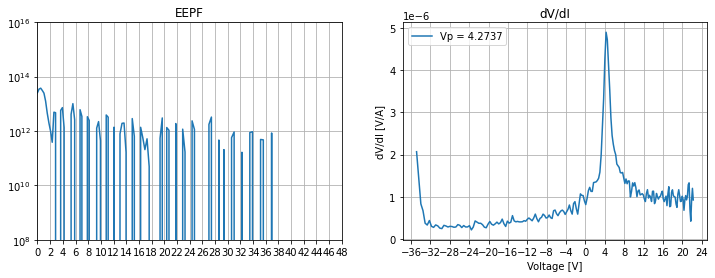

Enter limited energy
ne: 4.123e+13 [m-3]	 Te: 0.429 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.765	 gamma: 4.2871	 sol_number: 1
a_0: 6771.1954	 a_s: 4614.679	 gamma: 4.2871	 sol_number: 1
a_0: 2591.7200	 a_s: 1766.1176	 gamma: 4.2871	 sol_number: 1
a_0: 1477.9981	 a_s: 1007.0498	 gamma: 4.2871	 sol_number: 1
a_0: 1115.9447	 a_s: 760.2889	 gamma: 4.2871	 sol_number: 1
a_0: 969.6120	 a_s: 660.5544	 gamma: 4.2871	 sol_number: 1
a_0: 903.7871	 a_s: 615.6908	 gamma: 4.2871	 sol_number: 1
a_0: 872.5645	 a_s: 594.4107	 gamma: 4.2871	 sol_number: 1
a_0: 857.3585	 a_s: 584.047	 gamma: 4.2871	 sol_number: 1
a_0: 849.8549	 a_s: 578.9328	 gamma: 4.2871	 sol_number: 1
a_0: 846.1276	 a_s: 576.3925	 gamma: 4.2871	 sol_number: 1
a_0: 844.2701	 a_s: 575.1265	 gamma: 4.2871	 sol_number: 1
a_0: 843.3429	 a_s: 574.4945	 gamma: 4.2871	 sol_number: 1
Vp: 4.27374, Vsat: 34.8543, Isat: 2.9927e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/80.ldf


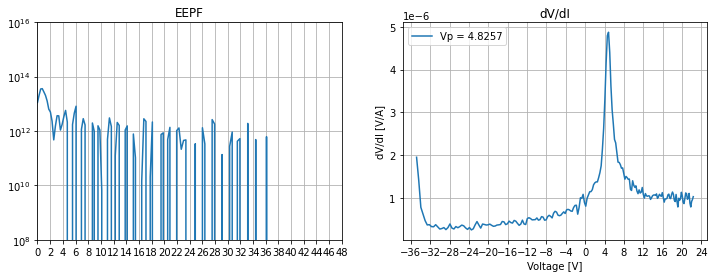

Enter limited energy
ne: 4.148e+13 [m-3]	 Te: 0.533 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.6736	 gamma: 5.3338	 sol_number: 1
a_0: 6722.7700	 a_s: 4477.9605	 gamma: 5.3338	 sol_number: 1
a_0: 2684.7468	 a_s: 1788.081	 gamma: 5.3338	 sol_number: 1
a_0: 1549.3113	 a_s: 1031.7246	 gamma: 5.3338	 sol_number: 1
a_0: 1176.7502	 a_s: 783.5476	 gamma: 5.3338	 sol_number: 1
a_0: 1025.4845	 a_s: 682.7838	 gamma: 5.3338	 sol_number: 1
a_0: 957.2875	 a_s: 637.3552	 gamma: 5.3338	 sol_number: 1
a_0: 924.9036	 a_s: 615.7831	 gamma: 5.3338	 sol_number: 1
a_0: 909.1233	 a_s: 605.2713	 gamma: 5.3338	 sol_number: 1
a_0: 901.3341	 a_s: 600.0825	 gamma: 5.3338	 sol_number: 1
a_0: 897.4644	 a_s: 597.5048	 gamma: 5.3338	 sol_number: 1
a_0: 895.5358	 a_s: 596.2201	 gamma: 5.3338	 sol_number: 1
a_0: 894.5730	 a_s: 595.5788	 gamma: 5.3338	 sol_number: 1
Vp: 4.82569, Vsat: 34.807, Isat: 3.04609e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/90.ldf


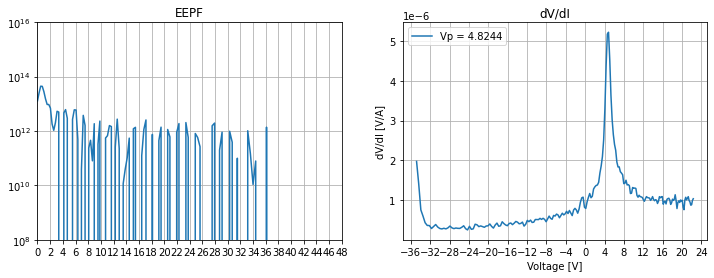

Enter limited energy
ne: 4.556e+13 [m-3]	 Te: 0.496 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.7023	 gamma: 4.9606	 sol_number: 1
a_0: 6135.2815	 a_s: 4115.5527	 gamma: 4.9606	 sol_number: 1
a_0: 2430.7574	 a_s: 1630.3619	 gamma: 4.9606	 sol_number: 1
a_0: 1401.3668	 a_s: 939.7923	 gamma: 4.9606	 sol_number: 1
a_0: 1063.8449	 a_s: 713.3647	 gamma: 4.9606	 sol_number: 1
a_0: 926.8532	 a_s: 621.4635	 gamma: 4.9606	 sol_number: 1
a_0: 865.1021	 a_s: 580.0375	 gamma: 4.9606	 sol_number: 1
a_0: 835.7815	 a_s: 560.3677	 gamma: 4.9606	 sol_number: 1
a_0: 821.4945	 a_s: 550.7833	 gamma: 4.9606	 sol_number: 1
a_0: 814.4425	 a_s: 546.0524	 gamma: 4.9606	 sol_number: 1
a_0: 810.9392	 a_s: 543.7022	 gamma: 4.9606	 sol_number: 1
a_0: 809.1931	 a_s: 542.5308	 gamma: 4.9606	 sol_number: 1
a_0: 808.3215	 a_s: 541.9461	 gamma: 4.9606	 sol_number: 1
Vp: 4.82437, Vsat: 34.8078, Isat: 3.035e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/100.ldf


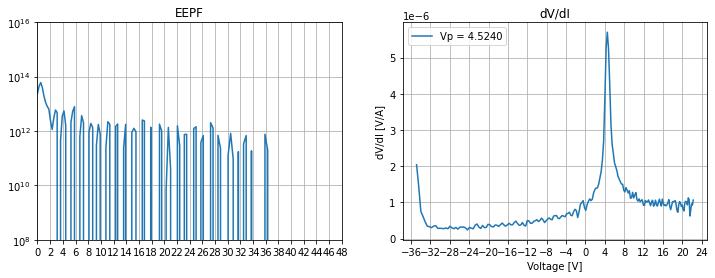

Enter limited energy
ne: 5.151e+13 [m-3]	 Te: 0.418 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.7769	 gamma: 4.1767	 sol_number: 1
a_0: 5427.5934	 a_s: 3710.3656	 gamma: 4.1767	 sol_number: 1
a_0: 2084.0483	 a_s: 1424.5013	 gamma: 4.1767	 sol_number: 1
a_0: 1191.7007	 a_s: 814.4347	 gamma: 4.1767	 sol_number: 1
a_0: 900.9617	 a_s: 615.6666	 gamma: 4.1767	 sol_number: 1
a_0: 783.3220	 a_s: 535.2406	 gamma: 4.1767	 sol_number: 1
a_0: 730.3749	 a_s: 499.0424	 gamma: 4.1767	 sol_number: 1
a_0: 705.2535	 a_s: 481.8679	 gamma: 4.1767	 sol_number: 1
a_0: 693.0173	 a_s: 473.5024	 gamma: 4.1767	 sol_number: 1
a_0: 686.9787	 a_s: 469.374	 gamma: 4.1767	 sol_number: 1
a_0: 683.9791	 a_s: 467.3233	 gamma: 4.1767	 sol_number: 1
a_0: 682.4842	 a_s: 466.3013	 gamma: 4.1767	 sol_number: 1
a_0: 681.7379	 a_s: 465.7911	 gamma: 4.1767	 sol_number: 1
Vp: 4.52398, Vsat: 34.8616, Isat: 2.99043e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/110.ldf


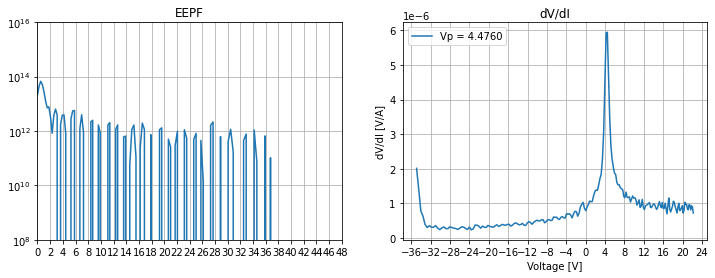

Enter limited energy
ne: 5.854e+13 [m-3]	 Te: 0.434 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.7596	 gamma: 4.3385	 sol_number: 1
a_0: 4608.3422	 a_s: 3136.2254	 gamma: 4.3385	 sol_number: 1
a_0: 1742.8113	 a_s: 1185.893	 gamma: 4.3385	 sol_number: 1
a_0: 987.2700	 a_s: 671.6579	 gamma: 4.3385	 sol_number: 1
a_0: 742.8746	 a_s: 505.3179	 gamma: 4.3385	 sol_number: 1
a_0: 644.3331	 a_s: 438.2488	 gamma: 4.3385	 sol_number: 1
a_0: 600.0581	 a_s: 408.1144	 gamma: 4.3385	 sol_number: 1
a_0: 579.0692	 a_s: 393.829	 gamma: 4.3385	 sol_number: 1
a_0: 568.8503	 a_s: 386.8738	 gamma: 4.3385	 sol_number: 1
a_0: 563.8082	 a_s: 383.4421	 gamma: 4.3385	 sol_number: 1
a_0: 561.3039	 a_s: 381.7376	 gamma: 4.3385	 sol_number: 1
a_0: 560.0559	 a_s: 380.8882	 gamma: 4.3385	 sol_number: 1
a_0: 559.4329	 a_s: 380.4642	 gamma: 4.3385	 sol_number: 1
Vp: 4.47599, Vsat: 34.9108, Isat: 2.89551e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/120.ldf


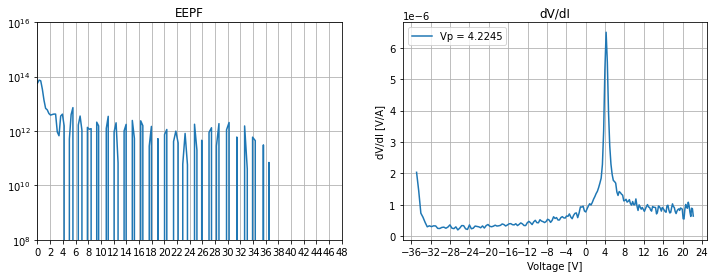

Enter limited energy
ne: 6.139e+13 [m-3]	 Te: 0.333 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.8903	 gamma: 3.3338	 sol_number: 1
a_0: 4406.8384	 a_s: 3105.1343	 gamma: 3.3338	 sol_number: 1
a_0: 1597.9306	 a_s: 1125.7733	 gamma: 3.3338	 sol_number: 1
a_0: 897.3759	 a_s: 632.1114	 gamma: 3.3338	 sol_number: 1
a_0: 672.3022	 a_s: 473.5081	 gamma: 3.3338	 sol_number: 1
a_0: 581.8520	 a_s: 409.7704	 gamma: 3.3338	 sol_number: 1
a_0: 541.2790	 a_s: 381.1797	 gamma: 3.3338	 sol_number: 1
a_0: 522.0609	 a_s: 367.6372	 gamma: 3.3338	 sol_number: 1
a_0: 512.7078	 a_s: 361.0463	 gamma: 3.3338	 sol_number: 1
a_0: 508.0939	 a_s: 357.7951	 gamma: 3.3338	 sol_number: 1
a_0: 505.8025	 a_s: 356.1804	 gamma: 3.3338	 sol_number: 1
a_0: 504.6607	 a_s: 355.3757	 gamma: 3.3338	 sol_number: 1
a_0: 504.0907	 a_s: 354.9741	 gamma: 3.3338	 sol_number: 1
Vp: 4.22451, Vsat: 34.9131, Isat: 2.83229e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/130.ldf


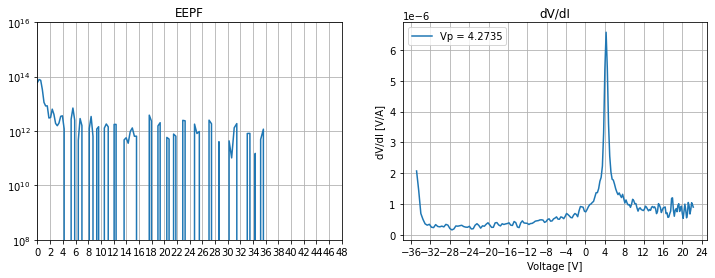

Enter limited energy
ne: 6.374e+13 [m-3]	 Te: 0.333 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.8912	 gamma: 3.3278	 sol_number: 1
a_0: 4128.4628	 a_s: 2909.7534	 gamma: 3.3278	 sol_number: 1
a_0: 1479.6679	 a_s: 1042.7176	 gamma: 3.3278	 sol_number: 1
a_0: 826.1759	 a_s: 582.0957	 gamma: 3.3278	 sol_number: 1
a_0: 617.1582	 a_s: 434.767	 gamma: 3.3278	 sol_number: 1
a_0: 533.3426	 a_s: 375.6886	 gamma: 3.3278	 sol_number: 1
a_0: 495.7859	 a_s: 349.2163	 gamma: 3.3278	 sol_number: 1
a_0: 478.0059	 a_s: 336.6838	 gamma: 3.3278	 sol_number: 1
a_0: 469.3550	 a_s: 330.5861	 gamma: 3.3278	 sol_number: 1
a_0: 465.0881	 a_s: 327.5786	 gamma: 3.3278	 sol_number: 1
a_0: 462.9691	 a_s: 326.085	 gamma: 3.3278	 sol_number: 1
a_0: 461.9132	 a_s: 325.3407	 gamma: 3.3278	 sol_number: 1
a_0: 461.3862	 a_s: 324.9692	 gamma: 3.3278	 sol_number: 1
Vp: 4.27348, Vsat: 34.8612, Isat: 2.75467e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/140.ldf


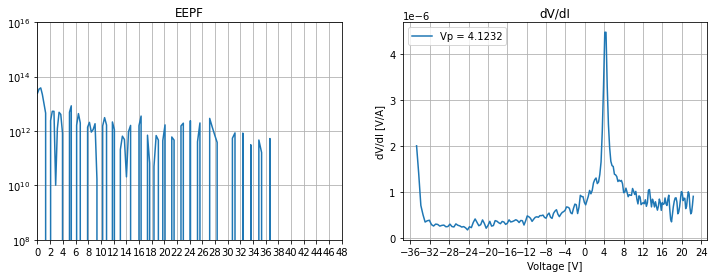

Enter limited energy
ne: 3.109e+13 [m-3]	 Te: 0.320 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.9133	 gamma: 3.1982	 sol_number: 1
a_0: 8091.8114	 a_s: 5738.234	 gamma: 3.1982	 sol_number: 1
a_0: 2818.3280	 a_s: 1998.4376	 gamma: 3.1982	 sol_number: 1
a_0: 1554.6685	 a_s: 1102.2882	 gamma: 3.1982	 sol_number: 1
a_0: 1154.4907	 a_s: 818.4941	 gamma: 3.1982	 sol_number: 1
a_0: 994.8057	 a_s: 705.2503	 gamma: 3.1982	 sol_number: 1
a_0: 923.4276	 a_s: 654.6311	 gamma: 3.1982	 sol_number: 1
a_0: 889.6772	 a_s: 630.6963	 gamma: 3.1982	 sol_number: 1
a_0: 873.2660	 a_s: 619.0579	 gamma: 3.1982	 sol_number: 1
a_0: 865.1739	 a_s: 613.3193	 gamma: 3.1982	 sol_number: 1
a_0: 861.1559	 a_s: 610.4698	 gamma: 3.1982	 sol_number: 1
a_0: 859.1539	 a_s: 609.05	 gamma: 3.1982	 sol_number: 1
a_0: 858.1546	 a_s: 608.3414	 gamma: 3.1982	 sol_number: 1
Vp: 4.12316, Vsat: 34.7301, Isat: 2.62316e-05




In [5]:
distances, nes, nms, alphas, Vps, Tes, Nis = [], [], [], [], [], [], []

ldf_files = parser.ldf_paths()
for file in ldf_files:
    IV, eedf, result = parser.pull_attr(file, need_return=True)
    print(file)
    distance = float(file.split('/')[-1][:-4])

    V = np.array(IV['V'])
    I = np.array(IV['I'])
    dIdV = np.gradient(I, V)
    Vsat, Isat = cal_sat(IV)
    Vp = cal_Vp(IV)
    my_V, my_eepf, my_eedf = cal_eepf(IV)
    #fig = plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_xticks(np.arange(0,50,2))
    ax[0].set_yscale('log')
    ax[0].grid(True)
    ax[0].set_title('EEPF')
    ax[0].set_xlim(0,)
    ax[0].set_ylim(1e8, 1e16)
    ax[0].plot(my_V, my_eepf)
    ax[1].set_xticks(np.arange(-40,40,4))
    ax[1].grid(True)
    ax[1].set_title('dV/dI')
    ax[1].set_ylabel('dV/dI [V/A]')
    ax[1].set_xlabel('Voltage [V]')
    ax[1].plot(V, dIdV)
    ax[1].legend(['Vp = {:.4f}'.format(Vp)])
    plt.show()
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)
    ne = cal_ne(my_V, my_eepf, V_lim)
    Te = cal_Te(my_V, my_eepf, ne, V_lim)
    #ne = cal_ne_with_Vp(IV, Te)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    
    exp = Iterative_method(ne,Te,Vsat,Isat,Vp)
    alpha = exp.iteration()
    nm = ne*alpha
    print("Vp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    
    Vps.append(Vp)
    alphas.append(alpha)
    nes.append(ne)
    nms.append(nm)
    distances.append(distance)
    Tes.append(Te)

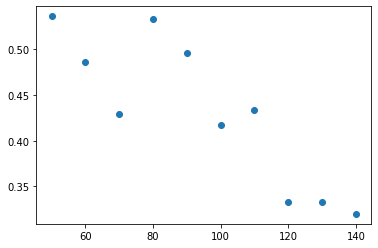

In [6]:
plt.scatter(distances, Tes)

Text(0, 0.5, '$\\alpha_0$')

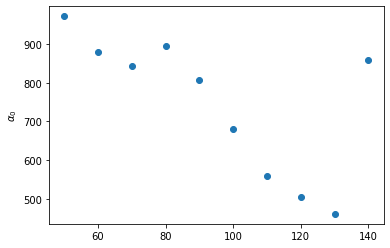

In [7]:
plt.scatter(distances, alphas)
plt.ylabel(r'$\alpha_0$')

In [8]:
distances

[50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0]

Text(0, 0.5, 'Electron density $[m^{-3}]$')

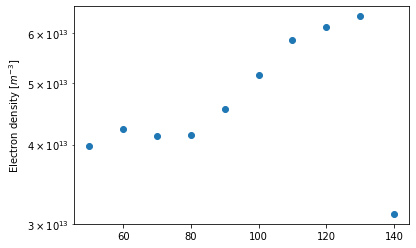

In [75]:
plt.scatter(distances, nes)
plt.yscale('log')
plt.ylabel('Electron density $[m^{-3}]$')

(0.0, 15.0)

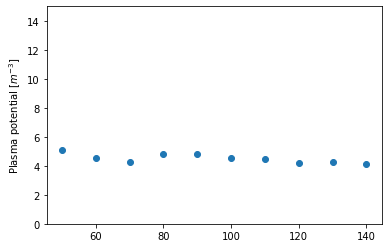

In [76]:
plt.scatter(distances, Vps)
plt.ylabel('Plasma potential $[m^{-3}]$')
plt.ylim(0,15)

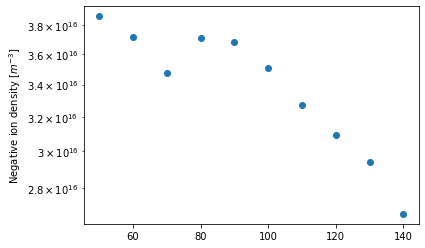

In [70]:
plt.ylabel('Negative ion density $[m^{-3}]$')
plt.scatter(distances, nms)
plt.yscale('log')

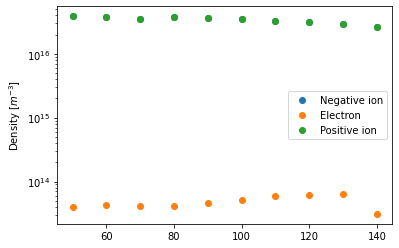

In [73]:
plt.scatter(distances, nms)
plt.scatter(distances, nes)
plt.scatter(distances, np.array(nes) + np.array(nms))
plt.yscale('log')
plt.ylabel('Density $[m^{-3}]$')
plt.legend(['Negative ion', 'Electron', 'Positive ion'])

The algorithm converged to the desired accuracy.


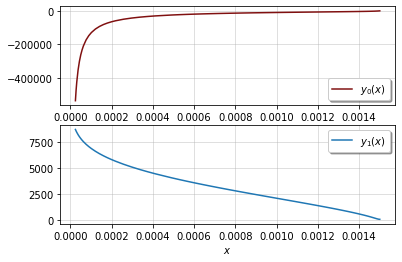

In [74]:
from scipy.integrate import solve_bvp
rp= 25e-6
J = 10
V = 50
uB = 100
R= 50e-5
def fun(r, y, r_sh):
    return np.vstack((r_sh*J/(r*epsilon_0*y[1])-y[0]/r, e*y[0]/(Mp*y[1])))

def bc(ya,yb,p):
    return np.array([yb[0],ya[1]-np.sqrt(2*e*V/Mp),yb[1]-uB])
# a=시작
# b=끝
# 0=E
# 1=u
n = 20
r = np.linspace(rp, 3*R, n)
y = np.array([np.linspace(V, 0, n)/(R-rp), np.linspace(np.sqrt(2*e*V/Mp), uB, n)])

sol = solve_bvp(fun, bc, r, y,p=(10*rp,))

if sol.status != 0:
    print("WARNING: sol.status is %d" % sol.status)
print(sol.message)

plt.subplot(2, 1, 1)
plt.plot(sol.x, sol.y[0], color='#801010', label='$y_0(x)$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.subplot(2, 1, 2)
plt.plot(sol.x, sol.y[1], '-', color='C0', label='$y_1(x)$')
plt.xlabel('$x$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.show()